# 1. Import essential libraries:

In [142]:
import os
import random
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd

# 2. Define path to example file:

In [143]:
PL_LANG_FILE = os.path.join('languages_audio', 'languages_audio_wav', 'pl', 'clips', 'common_voice_pl_20547814.wav')
PL_LANG_FILE

'languages_audio\\languages_audio_wav\\pl\\clips\\common_voice_pl_20547814.wav'

# 3. Load encoded audio file:

In [144]:
file_content = tf.io.read_file(PL_LANG_FILE)
file_content

<tf.Tensor: shape=(), dtype=string, numpy=b'RIFFFY\x07\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80\xbb\x00\x00\x00w\x01\x00\x02\x00\x10\x00LIST\x1a\x00\x00\x00INFOISFT\r\x00\x00\x00Lavf61.3.103\x00\x00data\x00Y\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

# 4. Decode wav audio file:

In [145]:
wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)

In [146]:
print(f'wav shape: {wav.shape}')
wav

wav shape: (240768, 1)


<tf.Tensor: shape=(240768, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [147]:
print(f'sample rate: {sample_rate.numpy()}')
sample_rate

sample rate: 48000


<tf.Tensor: shape=(), dtype=int32, numpy=48000>

# 5. Delete dimensions with shape 1 (in this case the last axis):

In [148]:
wav = tf.squeeze(wav, axis=-1)

In [149]:
print(f'new wav shape: {wav.shape}')

new wav shape: (240768,)


# 6. Resample audio file (in this case to 16 000 kHz):

In [150]:
''' librosa.resample() gets and returns a numpy array not tensorflow tensor '''
wav = librosa.resample(wav.numpy(), orig_sr=sample_rate.numpy(), target_sr=16_000)

In [151]:
wav.shape

(80256,)

# 7. Convert file to tensor:

In [152]:
wav_tensor = tf.convert_to_tensor(wav, dtype=tf.float32)
print(f'current wav type: {type(wav)}')

current wav type: <class 'numpy.ndarray'>


# 8. Plot audio:

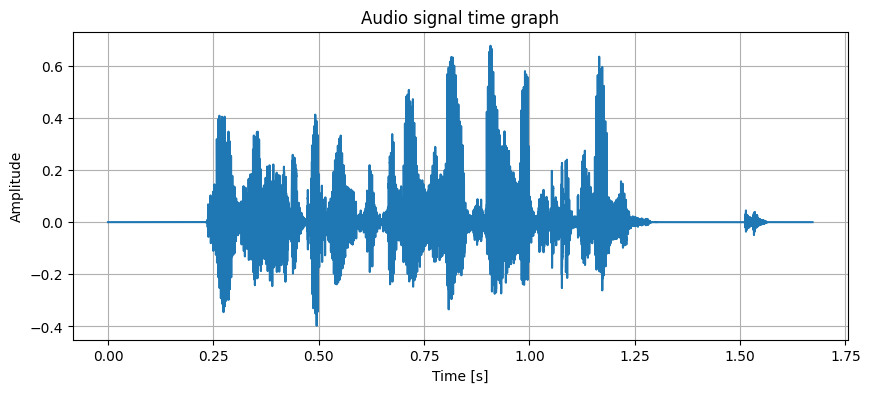

In [153]:
time_axis = np.linspace(0, len(wav) / sample_rate, num=len(wav))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# 9. Display audio:

In [154]:
ipd.Audio(PL_LANG_FILE)

# 10 Audio transformations:

### 10.1 Define functions to transform audio:

In [155]:
def increase_amplitude(wav, min_increase=2.0, max_increase=5.0):
    increased_wav = wav * random.uniform(min_increase, max_increase)
    return tf.convert_to_tensor(increased_wav, dtype=tf.float32)

''' Normalize from -1 to 1 '''
def normalize_audio(wav):
    max_amplitude = tf.reduce_max(tf.abs(wav))
    normalized_wav = wav / max_amplitude  
    return normalized_wav

def add_noise(wav, noise_level=0.1):
    noise = tf.random.normal(tf.shape(wav), mean=0.0, stddev=noise_level)
    return wav + noise

def time_masking(wav, max_mask_length=10000):
    if wav is None or tf.rank(wav) != 1:
        return wav

    if tf.shape(wav)[0] <= max_mask_length:
        return wav
    
    ''' Draw mask length '''
    mask_length = tf.random.uniform([], maxval=max_mask_length, dtype=tf.int32)
    
    ''' Check property of mask '''
    mask_start_max = tf.shape(wav)[0] - mask_length
    mask_start = tf.random.uniform([], maxval=mask_start_max, dtype=tf.int32)
    
    mask = tf.concat([
        tf.ones([mask_start]),
        tf.zeros([mask_length]),
        tf.ones([tf.shape(wav)[0] - mask_start - mask_length])
    ], axis=0)
    
    return wav * mask

def change_pitch(wav, sample_rate=16_000, pitch_shift=2):
    if type(wav) is not np.ndarray:
        wav = wav.numpy() 
    pitched_wav = librosa.effects.pitch_shift(wav, sr=sample_rate, n_steps=pitch_shift)
    return tf.convert_to_tensor(pitched_wav, dtype=tf.float32)

def speed_up_audio(wav, speed_factor=2):
    if type(wav) is not np.ndarray:
        wav = wav.numpy() 
    stretched_wav = librosa.effects.time_stretch(wav, rate=speed_factor)
    return stretched_wav

def slow_down_audio(wav, speed_factor=0.5):
    if type(wav) is not np.ndarray:
        wav = wav.numpy() 
    slowed_wav_np = librosa.effects.time_stretch(wav, rate=speed_factor)
    return tf.convert_to_tensor(slowed_wav_np, dtype=tf.float32)

def create_spectrogram(wav):
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

### 10.2 Change amplitude:

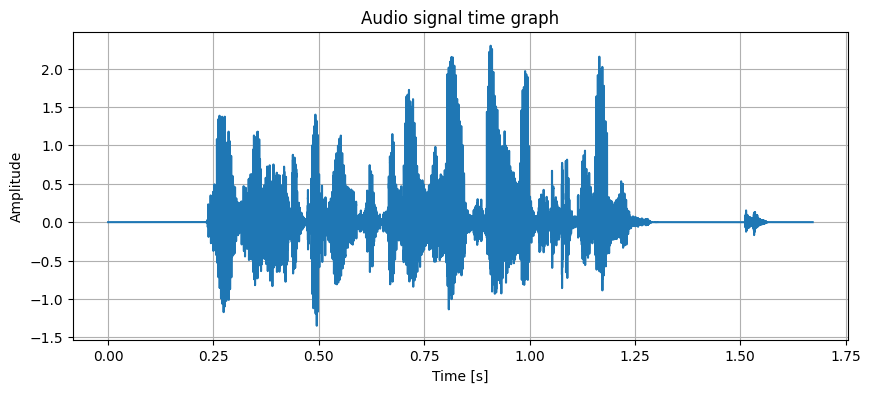

In [156]:
wav_amp = increase_amplitude(wav)

time_axis = np.linspace(0, len(wav_amp) / sample_rate, num=len(wav_amp))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_amp)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 10.3 Normalize audio:

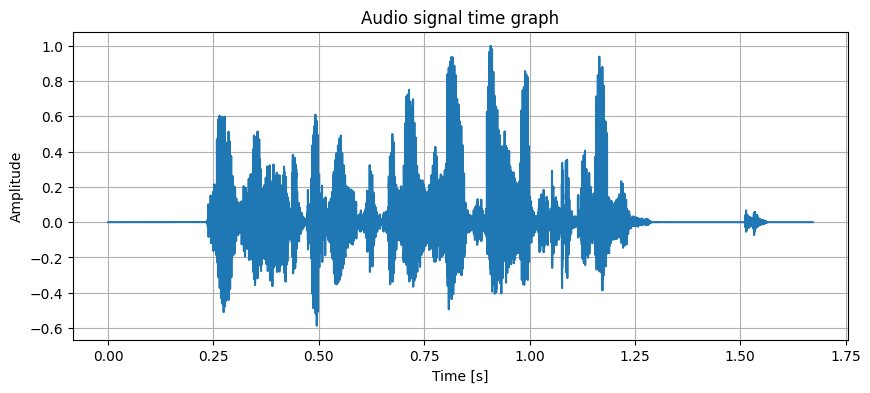

In [157]:
wav_norm = normalize_audio(wav)

time_axis = np.linspace(0, len(wav_norm) / sample_rate, num=len(wav_norm))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_norm)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 10.4 Add noise:

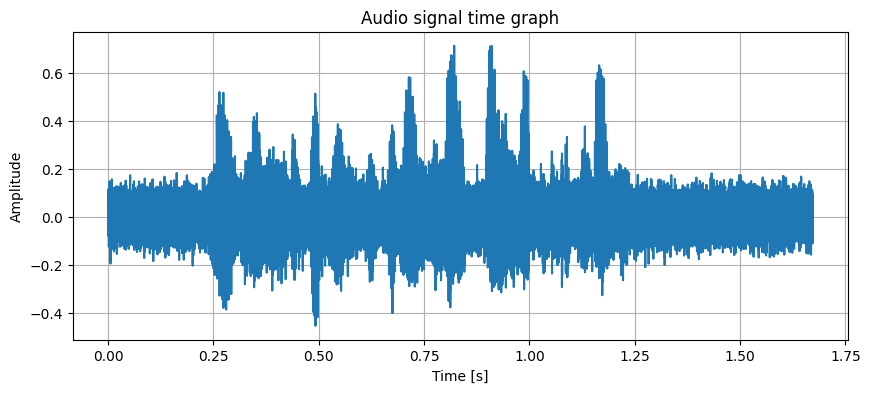

In [158]:
wav_noise = add_noise(wav, noise_level=0.05)
time_axis = np.linspace(0, len(wav_noise) / sample_rate, num=len(wav_noise))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_noise)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 10.5 Time masking:

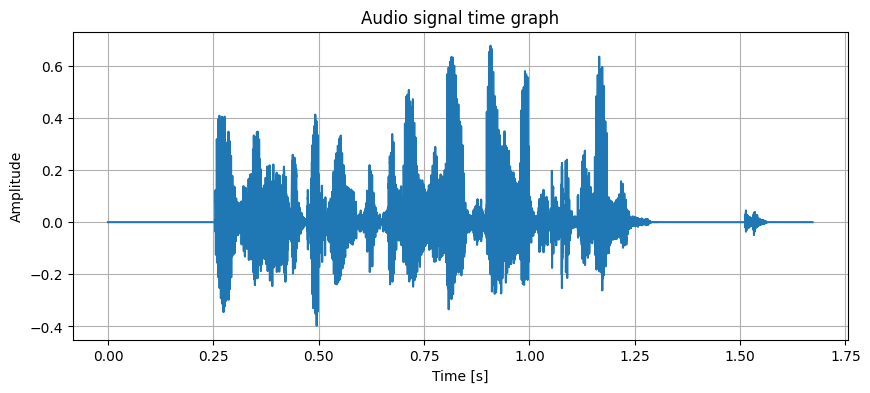

In [159]:
wav_time_mask = time_masking(wav, max_mask_length=7000)
time_axis = np.linspace(0, len(wav_time_mask) / sample_rate, num=len(wav_time_mask))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_time_mask)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 10.6 Change pitch:

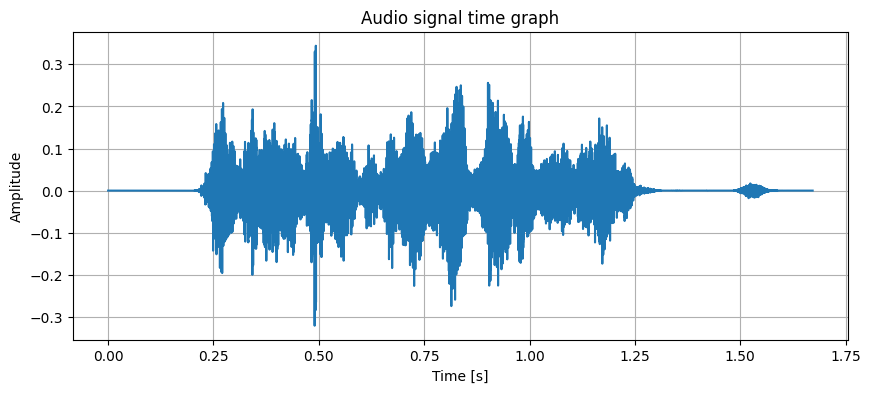

In [160]:
wav_pitch = change_pitch(wav) 
time_axis = np.linspace(0, len(wav_pitch) / sample_rate, num=len(wav_pitch))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_pitch)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 10.7 Speed up audio:

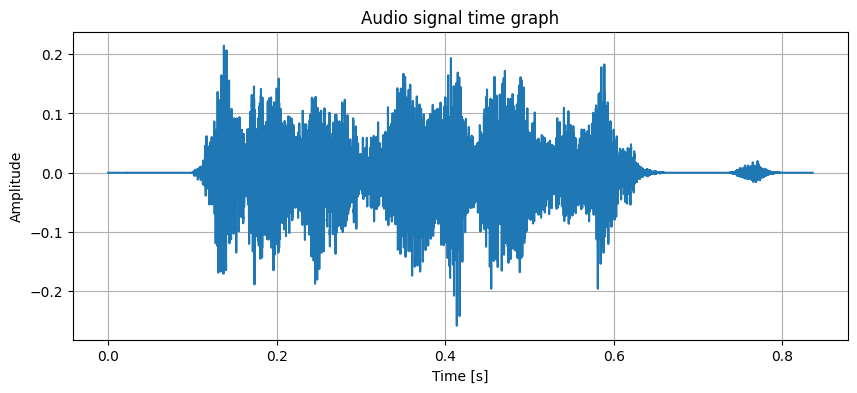

In [161]:
wav_speed_up = speed_up_audio(wav)
time_axis = np.linspace(0, len(wav_speed_up) / sample_rate, num=len(wav_speed_up))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_speed_up)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 10.8 Slow down audio:

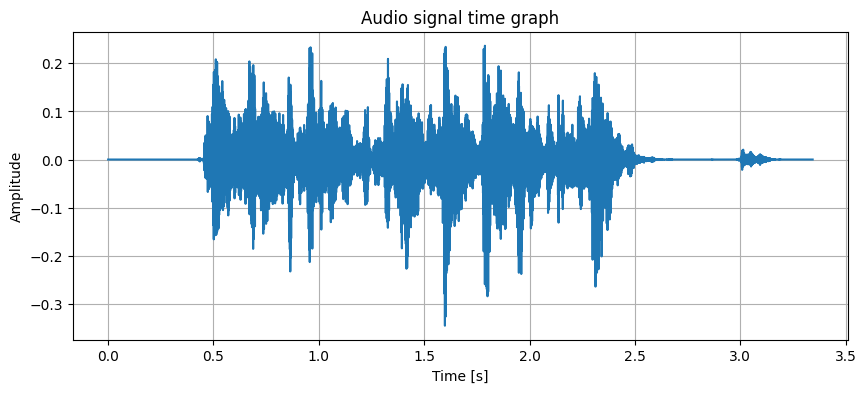

In [162]:
wav_slow_down= slow_down_audio(wav)
time_axis = np.linspace(0, len(wav_slow_down) / sample_rate, num=len(wav_slow_down))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_slow_down)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 10.9 Create spectrogram in magnitude:

In [163]:
spectrogram = create_spectrogram(wav)

print(f'Spectrogram shape: {spectrogram.shape}')
print(f'Number of time frames: {spectrogram.shape[0]}')
print(f'Frequency points for given time frame: {spectrogram.shape[1]}')
print(f'Number of channels of audio: {spectrogram.shape[2]}')

Spectrogram shape: (2499, 257, 1)
Number of time frames: 2499
Frequency points for given time frame: 257
Number of channels of audio: 1


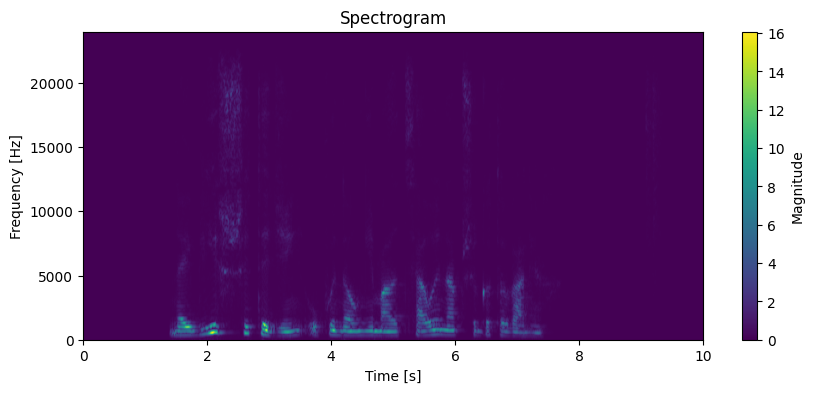

In [164]:
spectrogram = tf.squeeze(spectrogram, axis=-1)

plt.figure(figsize=(10, 4))
plt.imshow(tf.transpose(spectrogram), aspect='auto', origin='lower', cmap='viridis', extent=[0, 10, 0, sample_rate / 2])
plt.colorbar(label='Magnitude')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram')
plt.show()

### 10.10 Create spectrogram in log:

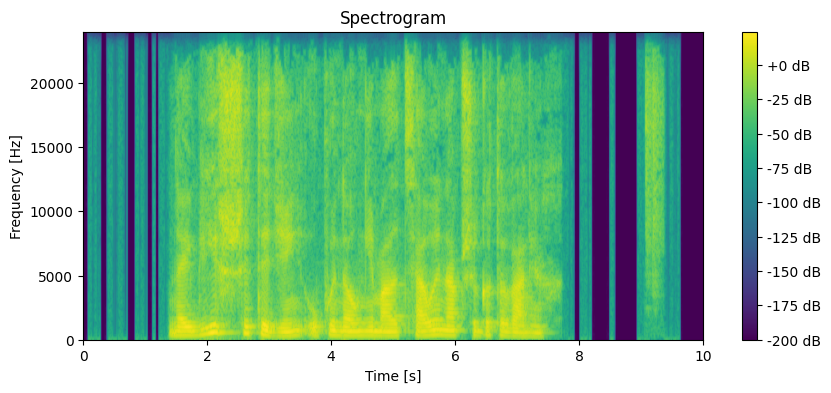

In [165]:
spectrogram_in_db = 20 * tf.math.log(spectrogram + 1e-10) / tf.math.log(10.0)
plt.figure(figsize=(10, 4))
plt.imshow(tf.transpose(spectrogram_in_db), aspect='auto', origin='lower', cmap='viridis', extent=[0, 10, 0, sample_rate / 2])
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram')
plt.show()